# Importing libraries

In [1]:
import numpy as np
import sympy as sp
from sympy import *
from scipy.optimize import line_search
import matplotlib.pyplot as plt
import pandas as pd

# Target Function

In [110]:
x = symbols('x')
func = x**2
func

x**2

In [56]:
def syms(func):
    return list(sp.ordered(func.free_symbols))
print(f"the input function has {len(syms(func))} variables: {syms(func)}")

the input function has 2 variables: [x, y]


### checking results with sympy

Gradient

In [57]:
Matrix([diff(func, syms(func)[i]) for i in range(len(syms(func)))])

Matrix([
[14*x - 70],
[  2*y - 6]])

Hessian

In [58]:
hessian(func, syms(func))

Matrix([
[14, 0],
[ 0, 2]])

# Calculating the gradient and the hessian matrix

In [6]:
def numpy_function(func, syms):
    return lambdify(syms, func, 'numpy')
def change_input_to_vector(function):
    return lambda x: np.array(function(*x)).squeeze()
def make_function(func, syms):
    return change_input_to_vector(numpy_function(func, syms))
def function(func):
    return make_function(func, syms(func))

In [7]:
def get_gradient(func):
    gradient_expression = Matrix([func]).jacobian(syms(func))
    return make_function(gradient_expression, syms(func))
def get_hessian_inverse(func):
    hessian_inverse_expression = hessian(func, syms(func))**-1
    return make_function(hessian_inverse_expression, syms(func))
def get_hessian_inverse_diagonal_expression(func):
    hessian_inverse_expression = hessian(func, syms(func))**-1
    return Matrix(*hessian_inverse_expression.shape,lambda i, j: hessian_inverse_expression[i, j] if i == j else 0)
def get_hessian_inverse_diagonal(func):
    return make_function(get_hessian_inverse_diagonal_expression(func), syms(func))
def convert_array_to_sympy_function(array, func):
    matrix = sympify(array)
    return make_function(matrix, syms(func))
def is_positive_definite(matrix):
    return Matrix(matrix).is_positive_definite

# Step size: constant - line search (strong wolfie) - back tracking (s, a, b)

Line search - Parameters
----------
- f : callable f(x,*args)
    Objective function.
- myfprime : callable f'(x,*args)
    Objective function gradient.
- xk : ndarray
    Starting point.
- pk : ndarray
    Search direction.

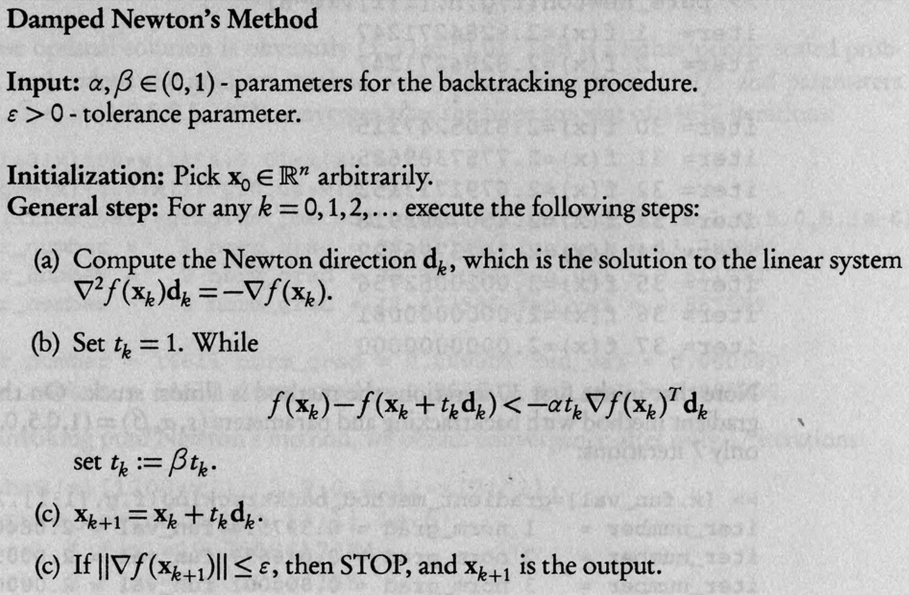

In [8]:

class Step:
    def __init__(self, value, method):
        self.value = value
        self.method = method

    def __call__(self, *args):
        return self.value


class constant(Step):
    def __init__(self, value):
        super().__init__(value, "")


class linesearch(Step):
    def __init__(self):
        super().__init__(None, "")

    def __call__(self, f, grad, xk, d):
        self.value = line_search(f, grad, xk, d)[0]
        return super().__call__()


class backtracking(Step):
    def __init__(self, s, alpha, beta):
        super().__init__(None, "")
        self.s = s
        self.alpha = alpha
        self.beta = beta

    def backtracing_line_search(self, f, grad, xk, d):
        t = self.s
        while f(xk) - f(xk + t * d) < -self.alpha * t * np.dot(grad(xk).T, d):
            t *= self.beta
        return t

    def __call__(self, f, grad, xk, d):
        self.value = self.backtracing_line_search(f, grad, xk, d)
        return super().__call__()

# Gradient Descent

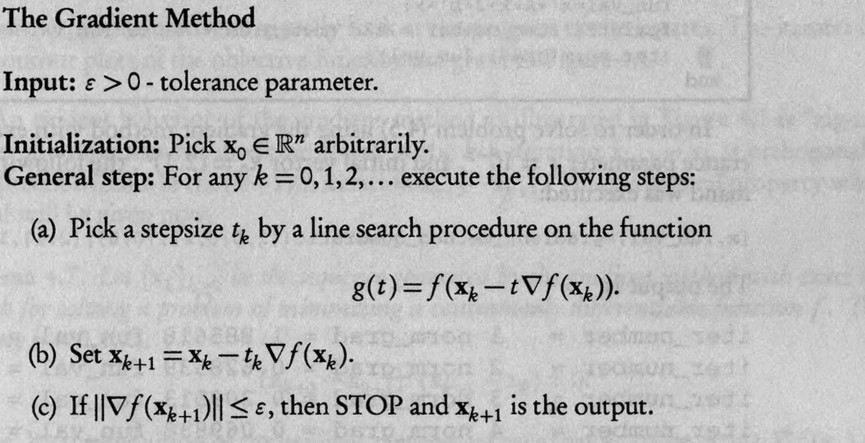

In [90]:
def gradient_descent(func, initial_x, step_method, epsilon, max_iter):

    iterr = 0
    xk = np.array(initial_x)
    f = function(func)
    grad = get_gradient(func)
    history = []
    history.append(xk)
    while np.linalg.norm(grad(xk)) > epsilon and iterr < max_iter:
        d = - grad(xk)
        step_size = step_method(f, grad, xk, d)
        xk = xk + step_size * d
        history.append(xk)
        iterr += 1

    return xk, f(xk), np.linalg.norm(grad(xk)), iterr, history

# Pure newton

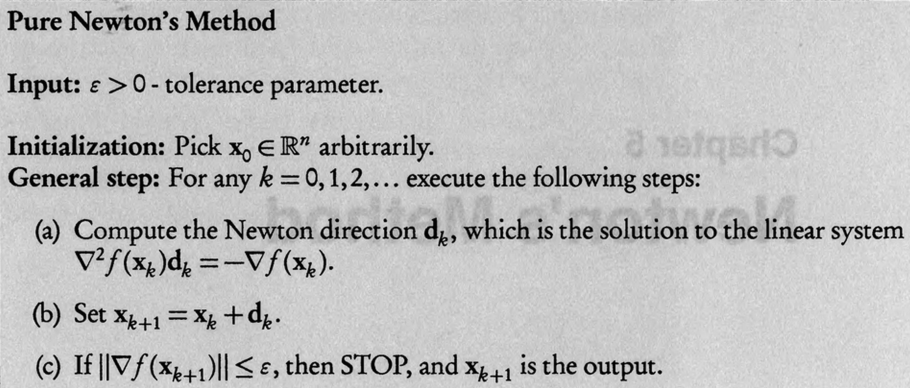

In [108]:
def pure_newton(func, initial_x, epsilon, max_iter):

    iterr = 0
    xk = np.array(initial_x)
    f = function(func)
    grad = get_gradient(func)
    hess_inv = get_hessian_inverse(func)
    history = []
    history.append(xk)
    while np.linalg.norm(grad(xk)) > epsilon and iterr < max_iter:
        d = -np.dot(hess_inv(xk), grad(xk))
        step_size = 1
        xk_p = xk
        xk = xk + step_size * d
        history.append(xk)
        iterr += 1
        if np.linalg.norm((xk - xk_p)) < 0.001:
            break
    return xk, f(xk), np.linalg.norm(grad(xk)), iterr, history

In [104]:
def damp_newton(func, initial_x, step_method, epsilon, max_iter):

    iterr = 0
    xk = np.array(initial_x)
    f = function(func)
    grad = get_gradient(func)
    hess_inv = get_hessian_inverse(func)
    history = []
    history.append(xk)
    while np.linalg.norm(grad(xk)) > epsilon and iterr < max_iter:
        d = -np.dot(hess_inv(xk), grad(xk))
        step_size = step_method(f, grad, xk, d)
        xk_p = xk
        xk = xk + step_size * d
        history.append(xk)
        iterr += 1
        if np.linalg.norm(xk - xk_p) < 0.001:
            break
    return xk, f(xk), np.linalg.norm(grad(xk)), iterr, history

# Hybrid Gradient-Newton 

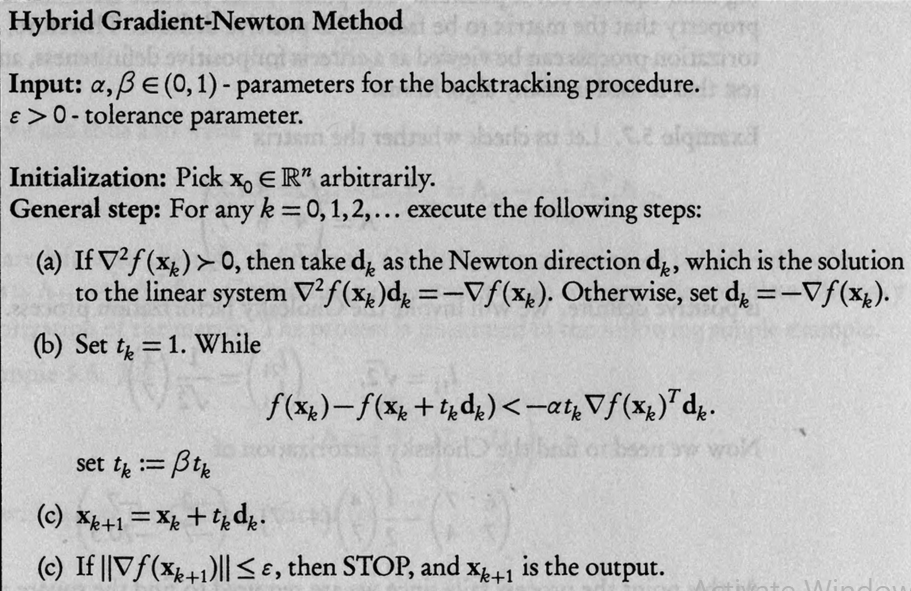

In [12]:
def hybrid_gradient_newton(func, initial_x, step_method, epsilon, max_iter):

    iterr = 0
    xk = np.array(initial_x)
    f = function(func)
    grad = get_gradient(func)
    hess_inv = get_hessian_inverse(func)
    history = []
    history.append(xk)
    
    while np.linalg.norm(grad(xk)) > epsilon and iterr < max_iter:
        if is_positive_definite(hess_inv(xk)):
            d = -np.dot(hess_inv(xk), grad(xk))
        else:
            d = -grad(xk)
        step_size = step_method(f, grad, xk, d)
        xk = xk + step_size * d
        history.append(xk)
        iterr += 1

    return xk, f(xk), np.linalg.norm(grad(xk)), iterr, history

# Initialization

In [111]:
func

x**2

In [112]:
func = func
initial_x = [1]
epsilon = 10^-5
max_iter = 1000

# Comparison

#### pure newton

In [109]:
 pure_newton(func, initial_x, epsilon, max_iter)

(array([5., 3.]),
 array(0.),
 0.0,
 2,
 [array([2, 7]), array([5., 3.]), array([5., 3.])])

In [63]:
x_min_newton, y_min_newton = pure_newton(func, initial_x, epsilon, max_iter)[0]
f_min_newton = pure_newton(func, initial_x, epsilon, max_iter)[1]
grad_min_newton = pure_newton(func, initial_x, epsilon, max_iter)[2]

In [65]:
print('the solution using pure newton method is at:')
Eq(Matrix([syms(func)[i] for i in range(len(syms(func)))]), Matrix([[x_min_newton], [y_min_newton]]))

the solution using pure newton method is at:


Eq(Matrix([
[x],
[y]]), Matrix([
[5.0],
[3.0]]))

In [66]:
print("the minimum value is: ")
g = Function('f')(x_min_newton, y_min_newton)
Eq(g, f_min_newton)

the minimum value is: 


Eq(f(5.0, 3.0), 0.0)

### backtracking

In [67]:
damp_newton(func, initial_x, backtracking(1, 0.5, 0.5), epsilon, max_iter)

(array([5., 3.]),
 array(0.),
 0.0,
 1000,
 [array([2, 7]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([

In [68]:
x_min_damp_newton, y_min_damp_newton = damp_newton(func, initial_x, backtracking(1, 0.5, 0.5), epsilon, max_iter)[0]
f_min_damp_newton = damp_newton(func, initial_x, backtracking(1, 0.5, 0.5), epsilon, max_iter)[1]

In [69]:
print('the solution using damp newton method is at:')
Eq(Matrix([syms(func)[i] for i in range(len(syms(func)))]), Matrix([[x_min_damp_newton], [y_min_damp_newton]]))

the solution using damp newton method is at:


Eq(Matrix([
[x],
[y]]), Matrix([
[5.0],
[3.0]]))

In [70]:
print("the minimum value is: ")
g = Function('f')(x_min_damp_newton, y_min_damp_newton)
Eq(g, f_min_damp_newton)

the minimum value is: 


Eq(f(5.0, 3.0), 0.0)

# GD

### constant

In [114]:
gradient_descent(func, initial_x, linesearch(), epsilon, max_iter)

(array([0.]),
 array(0.),
 0.0,
 1000,
 [array([1]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  array([0.]),
  

In [74]:
x_min_GD, y_min_GD = gradient_descent(func, initial_x, constant(0.001), epsilon, max_iter)[0]
f_min_GD = gradient_descent(func, initial_x, constant(0.001), epsilon, max_iter)[1]
grad_min_GD = gradient_descent(func, initial_x, constant(0.001), epsilon, max_iter)[2]

In [75]:
print('the solution using gradient descent method is at:')
Eq(Matrix([syms(func)[i] for i in range(len(syms(func)))]), Matrix([[x_min_GD], [y_min_GD]]))

the solution using gradient descent method is at:


Eq(Matrix([
[x],
[y]]), Matrix([
[4.99999999999997],
[3.00000000000011]]))

In [76]:
print("the minimum value is: ")
g = Function('f')(x_min_GD, y_min_GD)
Eq(g, f_min_GD)

the minimum value is: 


Eq(f(4.99999999999997, 3.00000000000011), 1.90904339063485e-26)

### linesearch

In [77]:
gradient_descent(func, initial_x, linesearch(), epsilon, max_iter)

(array([5., 3.]),
 array(0.),
 0.0,
 100000,
 [array([2, 7]),
  array([5.09281341, 6.41089268]),
  array([4.55590547, 3.59212604]),
  array([5.01373931, 3.50491959]),
  array([4.93426002, 3.08765331]),
  array([5.00203385, 3.07474401]),
  array([4.99026841, 3.01297545]),
  array([5.00030107, 3.01106447]),
  array([4.99855942, 3.00192078]),
  array([5.00004457, 3.00163789]),
  array([4.99978675, 3.00028434]),
  array([5.0000066 , 3.00024246]),
  array([4.99996843, 3.00004209]),
  array([5.00000098, 3.00003589]),
  array([4.99999533, 3.00000623]),
  array([5.00000014, 3.00000531]),
  array([4.99999931, 3.00000092]),
  array([5.00000002, 3.00000079]),
  array([4.9999999 , 3.00000014]),
  array([5.        , 3.00000012]),
  array([4.99999998, 3.00000002]),
  array([5.        , 3.00000002]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 3.]),
  array([5., 

In [78]:
x_min_GD, y_min_GD = gradient_descent(func, initial_x, linesearch(), epsilon, max_iter)[0]
f_min_GD = gradient_descent(func, initial_x, linesearch(), epsilon, max_iter)[1]
grad_min_GD = gradient_descent(func, initial_x, linesearch(), epsilon, max_iter)[2]

In [79]:
print('the solution using gradient descent method is at:')
Eq(Matrix([syms(func)[i] for i in range(len(syms(func)))]), Matrix([[x_min_GD], [y_min_GD]]))

the solution using gradient descent method is at:


Eq(Matrix([
[x],
[y]]), Matrix([
[5.0],
[3.0]]))

In [80]:
print("the minimum value is: ")
g = Function('f')(x_min_GD, y_min_GD)
Eq(g, f_min_GD)

the minimum value is: 


Eq(f(5.0, 3.0), 0.0)

# Hybrid

In [81]:
hybrid_gradient_newton(func, initial_x, constant(0.01), epsilon, max_iter)

(array([5., 3.]),
 array(1.37514233e-26),
 6.126783239057728e-13,
 100000,
 [array([2, 7]),
  array([2.03, 6.96]),
  array([2.0597, 6.9204]),
  array([2.089103, 6.881196]),
  array([2.11821197, 6.84238404]),
  array([2.14702985, 6.8039602 ]),
  array([2.17555955, 6.7659206 ]),
  array([2.20380396, 6.72826139]),
  array([2.23176592, 6.69097878]),
  array([2.25944826, 6.65406899]),
  array([2.28685377, 6.6175283 ]),
  array([2.31398524, 6.58135302]),
  array([2.34084538, 6.54553949]),
  array([2.36743693, 6.51008409]),
  array([2.39376256, 6.47498325]),
  array([2.41982494, 6.44023342]),
  array([2.44562669, 6.40583108]),
  array([2.47117042, 6.37177277]),
  array([2.49645872, 6.33805505]),
  array([2.52149413, 6.3046745 ]),
  array([2.54627919, 6.27162775]),
  array([2.5708164 , 6.23891147]),
  array([2.59510823, 6.20652236]),
  array([2.61915715, 6.17445713]),
  array([2.64296558, 6.14271256]),
  array([2.66653592, 6.11128544]),
  array([2.68987056, 6.08017258]),
  array([2.71297186, 6

backtracking

In [42]:
gradient_descent(func, initial_x, backtracking(1, 0.5, 0.5), epsilon, max_iter)

(array([5., 3.]),
 array(0.),
 0.0,
 1000,
 [array([2, 7]),
  array([4.625, 6.5  ]),
  array([5.28125, 5.625  ]),
  array([4.7890625, 4.96875  ]),
  array([5.15820312, 4.4765625 ]),
  array([4.88134766, 4.10742188]),
  array([5.08898926, 3.83056641]),
  array([4.93325806, 3.6229248 ]),
  array([5.05005646, 3.4671936 ]),
  array([4.96245766, 3.3503952 ]),
  array([5.02815676, 3.2627964 ]),
  array([4.97888243, 3.1970973 ]),
  array([5.01583818, 3.14782298]),
  array([4.98812137, 3.11086723]),
  array([5.00890897, 3.08315042]),
  array([4.99331827, 3.06236282]),
  array([5.0050113 , 3.04677211]),
  array([4.99624153, 3.03507909]),
  array([5.00281886, 3.02630931]),
  array([4.99788586, 3.01973199]),
  array([5.00158561, 3.01479899]),
  array([4.9988108 , 3.01109924]),
  array([5.0008919 , 3.00832443]),
  array([4.99933107, 3.00624332]),
  array([5.0005017 , 3.00468249]),
  array([4.99962373, 3.00351187]),
  array([5.0002822, 3.0026339]),
  array([4.99978835, 3.00197543]),
  array([5.0001